In [1]:
import mnist
import scipy.misc
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import random
from einops import rearrange, reduce, repeat
from skimage.transform import resize

In [39]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,)) # normalize the data
])

# Download the MNIST training set and apply the transform
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download the MNIST test set and apply the transform
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a dataloader to load the training set in batches during training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Create a dataloader to load the test set in batches during evaluation
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


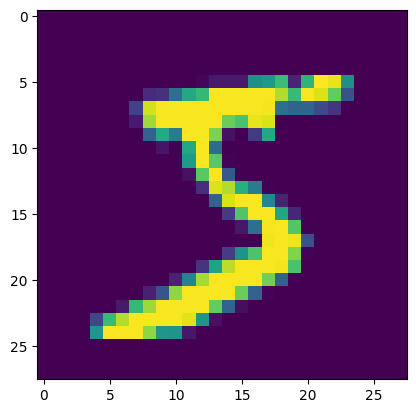

In [3]:
plt.imshow(trainset[0][0][0])

In [4]:
#import torchvision
#from torch.utils.data import DataLoader
#
#train_data = torchvision.datasets.MNIST
#
#images = mnist.train_images()
#labels = mnist.train_labels()
#
#def convert(image): return t.tensor(image.flatten()).float()
#train = t.stack([t.tensor(x,dtype=t.float)/256.0 for x in mnist.train_images()])
#mean = train.mean(dim=(0,1,2), keepdim=True)
#std = train.std(dim=(0,1,2), keepdim=True)
#train_normalized = (train - mean) / std

In [5]:
latent_dim = 10 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(784, latent_dim)
        self.decoder = nn.Linear(latent_dim, 784)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
#autoencoder = Autoencoder()
#optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
#loss_fn = nn.MSELoss()
#autoencoder.train()
#
## Train the autoencoder
#for epoch in range(10):  # train for 10 epochs
#    for batch_idx, (data, _) in enumerate(trainloader):
#        optimizer.zero_grad()  # zero the gradients
#        data = data.view(data.size(0), -1)  # flatten the images
#        recon = autoencoder(data)  # forward pass
#        loss = loss_fn(recon, data)  # compute the loss
#        loss.backward()  # backward pass
#        optimizer.step()  # update the parameters
#
#        if batch_idx % 1000 == 0:
#            print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch, batch_idx, loss.item()))
#            t.save(autoencoder.state_dict(), 'autoencoder.pt')
#
## Save the trained model
#t.save(autoencoder.state_dict(), 'autoencoder.pt')
#

Autoencoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (decoder): Linear(in_features=10, out_features=784, bias=True)
)


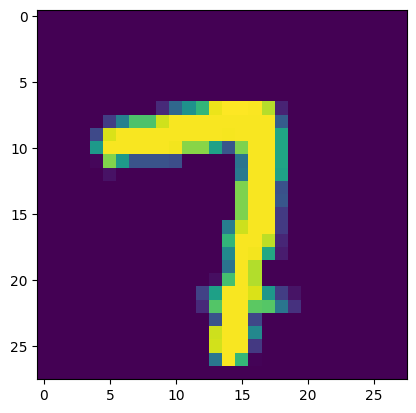

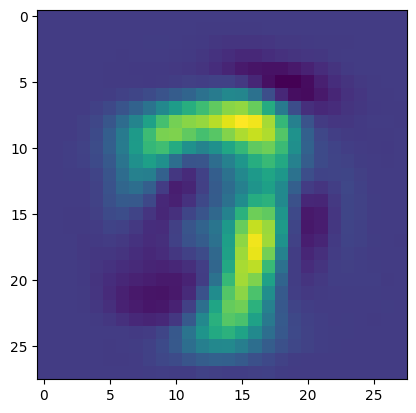

In [7]:
auto = Autoencoder()
auto.load_state_dict(t.load('autoencoder.pt'))
auto.eval()
print(auto)

a, (b,c) = next(enumerate(trainloader))
d = rearrange(auto(b.view(b.size(0),-1)), 'b (h w) -> b h w', h=28)
plt.figure()
plt.imshow(b[0][0].detach().numpy())
plt.figure()
plt.imshow(d[0].detach().numpy())

In [8]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
#classifier = DigitClassifier()
#optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
#classifier.train()
#
##loss_fn = nn.CrossEntropyLoss()
#
#for epoch in range(4):  # train for 10 epochs
#    for batch_idx, (data, label) in enumerate(trainloader):
#        optimizer.zero_grad()  # zero the gradients
#        data = data.view(data.size(0), -1)  # flatten the images
#        #loss = -t.log(classifier(data)[t.arange(label.shape[0]), label]).sum()
#        probs = t.nn.functional.softmax(classifier(data),dim=-1)  # forward pass
#        loss = -t.log(probs[t.arange(label.shape[0]), label]).sum()
#        #loss = loss_fn(probs, label)  # compute the loss
#        loss.backward()  # backward pass
#        optimizer.step()  # update the parameters
#
#        if batch_idx % 500 == 0:
#            #print(data.shape, label)
#            print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch, batch_idx, loss.item()))
#            t.save(classifier.state_dict(), 'classifier.pt')


In [10]:
classifier = DigitClassifier()
classifier.load_state_dict(t.load('classifier.pt'))
classifier.eval()
print(classifier)

DigitClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [42]:
# test
correct = []
classifier.eval()
for epoch in range(4):  
    for batch_idx, (data, label) in enumerate(testloader):
        data = data.view(data.size(0), -1).squeeze().squeeze()  # flatten the images
        probs = t.nn.functional.softmax(classifier(data),dim=-1)  # forward pass
        correct.append(1 if t.argmax(probs)==label.squeeze().squeeze() else 0)

def average(lst): 
    return sum(lst) / len(lst)

print("Test loss: ", average(correct))


Test loss:  0.959


In [40]:
for a,(b,c) in enumerate(testloader):
    print(b.shape)
    break

torch.Size([1, 1, 28, 28])


tensor(7)


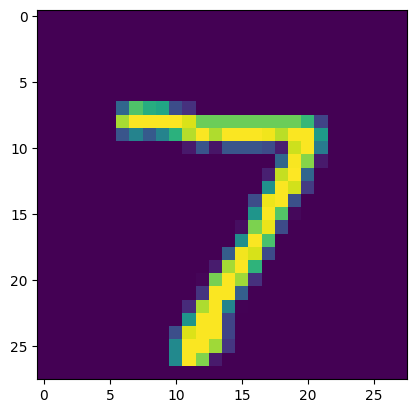

In [45]:
batch_idx = 0
a, (b,c) = next(enumerate(testloader)) 
d = classifier(b.view(b.size(0),-1))
plt.figure()
plt.imshow(b[batch_idx][0].detach().numpy())
print(c[batch_idx])

Prob:  tensor(0.9972, grad_fn=<SelectBackward0>)


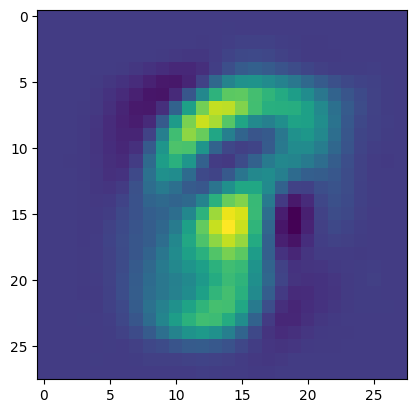

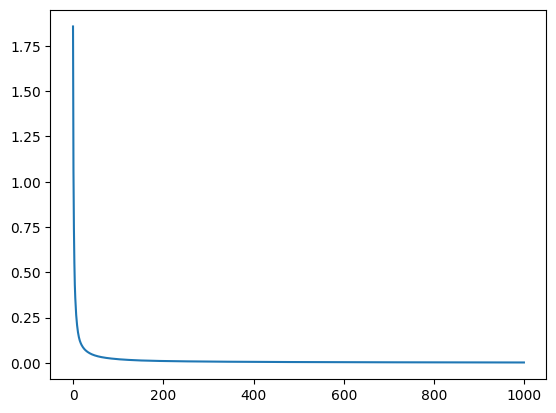

In [61]:
classifier = DigitClassifier()
classifier.load_state_dict(t.load('classifier.pt'))
target_class = 7 
learning_rate = 0.1
num_iterations = 1000
loss_fn = nn.CrossEntropyLoss()

losses = []
# Initialize the input tensor with random values
input_tensor = torch.randn(1, latent_dim, requires_grad=True)
# Perform gradient ascent to maximize the probability of the target class
for i in range(num_iterations):
    #probs = F.softmax(logits, dim=1)
    #loss = -torch.log(probs[0, target_class])
    logits = classifier(auto.decoder(input_tensor))
    #probs = t.nn.functional.softmax(logits,dim=-1)  # forward pass
    #loss = -t.log(probs[0, target_class])
    loss = loss_fn(logits, t.tensor([target_class]))
    #loss = loss_fn(logits, target_class)
    loss.backward()
    losses.append(loss.item())
    with torch.no_grad():
        input_tensor -= learning_rate * input_tensor.grad
    input_tensor.grad.zero_()

#input_tensor = torch.randn(1, latent_dim, requires_grad=True)
# Print the final input tensor and probability of the target class
plt.imshow(rearrange(auto.decoder(input_tensor)[0], '(h w) -> h w', h = 28).detach().numpy())
print("Prob: ", t.nn.functional.softmax(classifier(auto.decoder(input_tensor)),dim=-1)[0, target_class])
#print('Probability of target class:', probs[0, target_class])
plt.figure()
plt.plot(losses)


In [15]:
auto.decoder(torch.randn(1, 784))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x784 and 10x784)

In [ ]:
classifier(t.randn(1,784)).shape

torch.Size([1, 10])

In [ ]:
classifier = DigitClassifier()
classifier.load_state_dict(t.load('classifier.pt'))
auto = Autoencoder()
auto.load_state_dict(t.load('autoencoder.pt'))
classifier.train()

target_class = 4
learning_rate = 0.1
num_iterations = 1000
losses = []

# Initialize the input tensor with random values
input_tensor = torch.randn(1, latent_dim, requires_grad=True)
# Perform gradient ascent to maximize the probability of the target class
for i in range(num_iterations):
    logits = classifier(auto.decoder(input_tensor))
    probs = t.nn.functional.softmax(classifier(data),dim=-1)  # forward pass
    loss = -t.log(probs[t.arange(label.shape[0]), label]).sum()
    losses.append(loss.item())
    print(input_tensor.grad)
    loss.backward()
    with torch.no_grad():
        input_tensor -= learning_rate * input_tensor.grad
    input_tensor.grad.zero_()

# Print the final input tensor and probability of the target class
plt.imshow(rearrange(auto.decoder(input_tensor)[0], '(h w) -> h w', h = 28).detach().numpy())
print("logit: ")
print(classifier(auto.decoder(input_tensor))[0, target_class])
#print('Probability of target class:', probs[0, target_class])
plt.figure()
plt.plot(losses)


None


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
# Define the model
model = DigitClassifier()

# Create a dictionary to store the activations of each layer
activations = {}

# Define the forward hook function to capture the activations of each layer
def capture_activations(name):
    def hook(model, input, output):
        activations[name] = output
    return hook

# Register the forward hook for each layer of the model
for name, module in model.named_modules():
    module.register_forward_hook(capture_activations(name))

# Forward pass the input through the model to capture the activations
input_tensor = torch.randn(1, 784)
model(input_tensor)

# Print the activations of each layer
#for name, output in activations.items():
#    print(f'{name}: {output}')


tensor([[0.1081, 0.1081, 0.1093, 0.0929, 0.0910, 0.0806, 0.0914, 0.1141, 0.0915,
         0.1130]], grad_fn=<SoftmaxBackward0>)

In [ ]:
activations.keys()

dict_keys(['fc1', 'fc2', 'fc3', ''])

In [ ]:
t.tensor(3)

tensor(3)